# Create the code to test REPUBLIC with lots of PLATO-like light curves
##### Oscar Barragán, Nov 2023

In [1]:
#Load the libraries
from __future__ import division, absolute_import, print_function
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
from matplotlib import gridspec
#Be sure you have citlalicue installed, if not, install it with
#pip install citlalicue
from citlalicue.citlalicue import citlali
#The republic module is inside this directory
import republic
import seaborn as sns
sns.set_theme(style="white")
sns.set_context("paper")

Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
#DEFINE THE MULTICAMERA CONFIGURATION HERE
#I create the data set for 24 cameras, but later it can be changed to 
#run with less cameras taking subsets of the 24 cameras array
J = 24  # number of cameras
N = 4    # number of trends per camera
K = 1000 # number of observations
N_lcs = 1000 #Number of light curves
kepler_quarter = 10 #Select the Kepler quarter that we are using to obtain the Cotrending Basis Vectors
t = np.linspace(0,90,K)  #Time span to simulate the observations
np.random.seed(1) #Random seed to ensure reproducibility between different runs of this code

## Let us create the light curves

In [3]:
#Ranges to create the light curves

#QP kernel hyper parameters
Amps = [1e-5,5e-3]
les  = [10,1000]
lps  = [0.1,2]
Pgps = [3,30]

#Planet parameters
t0s  = [0,5]
Ps   = [0,10]
bs   = [0,1]
ars  = [1.5,50]
rps  = [0.01,0.1]

In [4]:
#Create the light curves
#lcs is a list that contain all the light curve objects
lcs = [None]*N_lcs
for i in tqdm(range(N_lcs)):
    #Let us create a light curve using citlalicue
    lc = citlali(time=t) 
    #In this case, we just need to call the add_spots method
    Amp = np.random.uniform(*Amps)
    le  = np.random.uniform(*les)
    lp  = np.random.uniform(*lps)
    Pgp = np.random.uniform(*Pgps)
    lc.add_spots(QP=[Amp,le,lp,Pgp])
    T0 = np.random.uniform(*t0s)
    P  = np.random.uniform(*Ps)
    b  = np.random.uniform(*bs)
    a  = np.random.uniform(*ars)
    rp = np.random.uniform(*rps)
    u1 = 0
    u2 = 0
    #Let us create a list with all the planet parameters
    planet_parameters = [T0,P,b,a,rp,u1,u2]
    #Let us add the planet by calling the add_transits method
    lc.add_transits(planet_parameters=planet_parameters,planet_name='b')
    #lc.plot(fsx=20,fsy=5)

    #Let's store the current light curve instance in the master list
    lcs[i] = lc

100%|███████████████████████████████████████████████████████████| 1000/1000 [19:32<00:00,  1.17s/it]


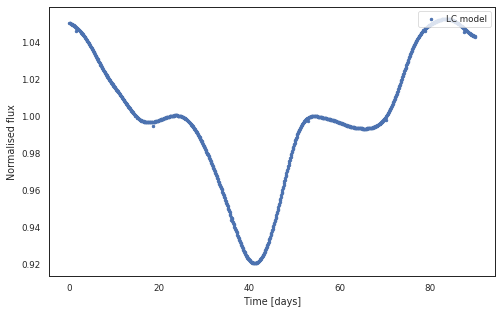

In [5]:
#Check that the instances have light curves
lcs[9].plot()

## Time to create the trends that will mimic the camera-like systematics
We are creating a master set with 24 cameras, and uncorrelated systatics, then using this we can easily create trends with correlated systematics and/or less cameras

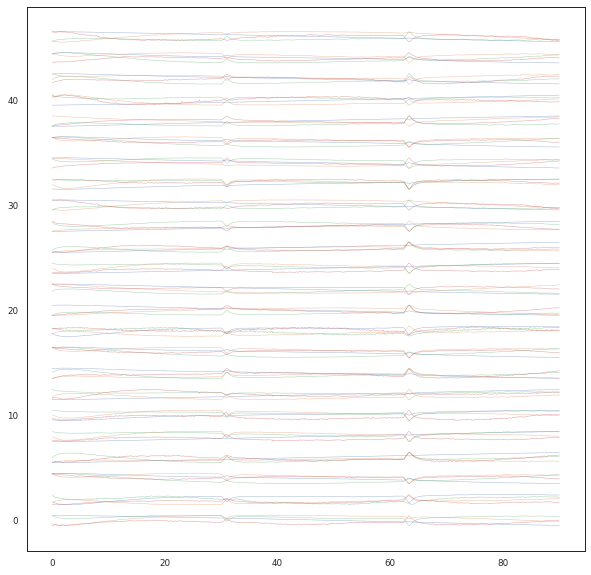

In [6]:
#Let us create the different sets of systematic treds
#create_kepler_CBVs is a function inside republic.py
T_master = republic.create_kepler_CBVs(t,quarter=kepler_quarter,N_cameras=J,ndata=K,N_trends=N,plot_cbvs=True)

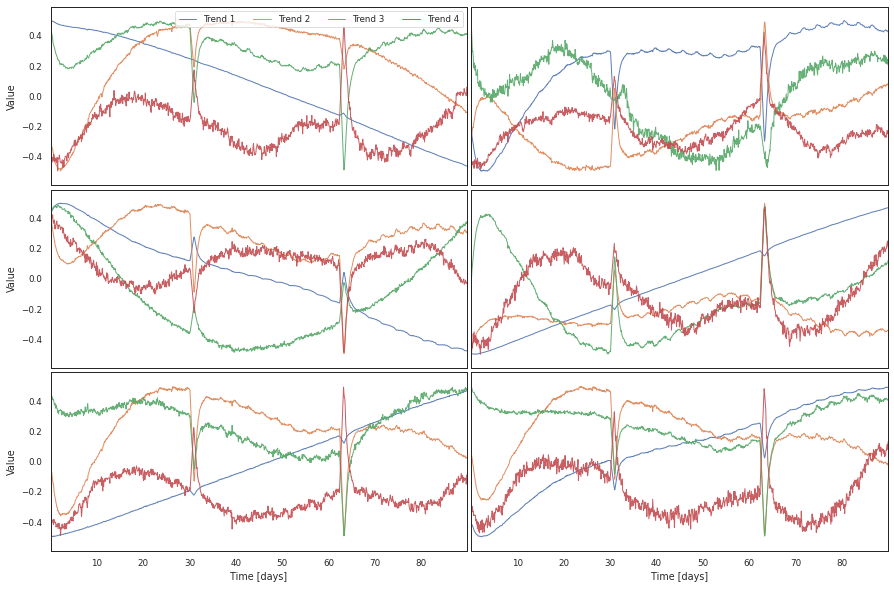

In [7]:
#Create a plot with the systematics of different cameras
fig = plt.figure(1,figsize=(15,10))
gs = gridspec.GridSpec(nrows=3,ncols=2)
gs.update(hspace=0.025)
gs.update(wspace=0.01)
cameras = [0,1,2,3,4,5]
#
for i,cam in enumerate(cameras):
    plt.subplot(gs[i])
    for j in range(N):
        if i == 0:
            plt.plot(t,T_master[cam,:,j],alpha=0.9,label='Trend '+str(j+1),lw=1)
        else:
            plt.plot(t,T_master[cam,:,j],alpha=0.9,lw=1)
    if i == 0:
        plt.legend(loc=1,ncols=4,frameon=True)
    if i%gs.ncols != 0:
        plt.tick_params(axis='y',labelleft=False,left=False)
    else:
        plt.ylabel('Value')
    plt.xlabel('Time [days]')
    plt.xlim(0.01,89.9)
    plt.ylim(-0.59,0.59)

out_file = 'trends.pdf'
plt.savefig(out_file,bbox_inches='tight',dpi=300)

## Time to platorize the light curves

In [8]:
#LEt us create the PLATO-like data for all cameras adding a new attribute to the lcs[i] instances
#All stars will have the same trends
sig = 0.0005
for i in range(N_lcs):
    lcs[i].plato = republic.platorize(lcs[i].flux,T_master,J,N,K,sig=sig)

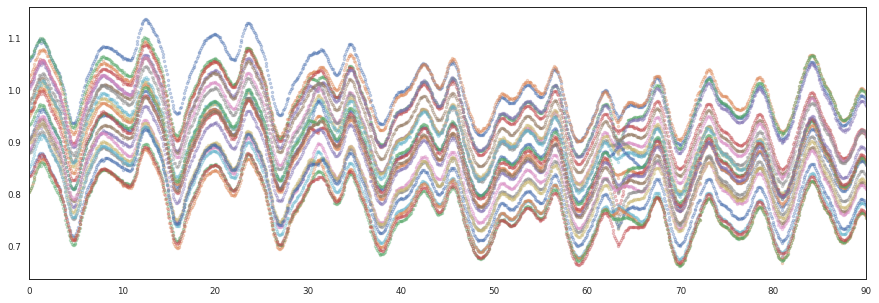

In [9]:
#Plot only one light curve to check that everything is OK
plt.figure(figsize=(15,5))
n = 0 #Let us plot the first light curve
for i in range(J):
    plt.plot(t,lcs[n].plato[i]-i*0.01,'.',alpha=0.3)
plt.xlim(t.min(),t.max())
plt.show()

In [10]:
#Tests can be done with less light curves to make this notebook run faster
N_l = 100
#To run with the whole set of light curves uncomment the next line
#N_l = N_lcs

## Let us correct the light curves using republic with 6, 12 and 24 cameras

In [11]:
#Run republic for all cameras
for i in tqdm(range(N_l)):
    #6 cameras
    #Let us do the republic magic correcting with a different number of cameras each time
    ncam=6
    T_use = T_master[:ncam,:,:] 
    sigma = np.zeros((ncam,K)) + sig
    lcs[i].a_6, lcs[i].w_6, lcs[i].B_6 = republic.republic_solve(lcs[i].plato[0:ncam], T_use, sigma)
    #12 cameras
    ncam=12
    T_use = T_master[:ncam,:,:] 
    sigma = np.zeros((ncam,K)) + sig
    lcs[i].a_12, lcs[i].w_12, lcs[i].B_12 = republic.republic_solve(lcs[i].plato[0:ncam], T_use, sigma)
    #24 cameras
    ncam=24
    T_use = T_master[:ncam,:,:] 
    sigma = np.zeros((ncam,K)) + sig
    lcs[i].a_24, lcs[i].w_24, lcs[i].B_24 = republic.republic_solve(lcs[i].plato[0:ncam], T_use, sigma)

100%|█████████████████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


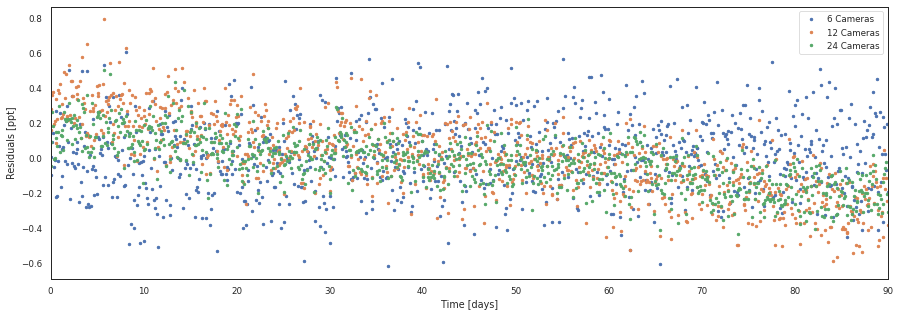

In [12]:
nl = 5
fig = plt.figure(1,figsize=(15,5),rasterized=True)
plt.plot(lcs[nl].time,(lcs[nl].a_6 -lcs[nl].flux)*1e3,'.',label= '6 Cameras',lw=0.5)
plt.plot(lcs[nl].time,(lcs[nl].a_12-lcs[nl].flux)*1e3,'.',label='12 Cameras',lw=0.5)
plt.plot(lcs[nl].time,(lcs[nl].a_24-lcs[nl].flux)*1e3,'.',label='24 Cameras',lw=0.5)
plt.ylabel('Residuals [ppt]')
plt.xlabel('Time [days]')
plt.legend(frameon=True)
plt.xlim(t.min(),t.max())
out_file = 'cameras_differences.pdf'
plt.savefig(out_file,bbox_inches='tight',dpi=300)

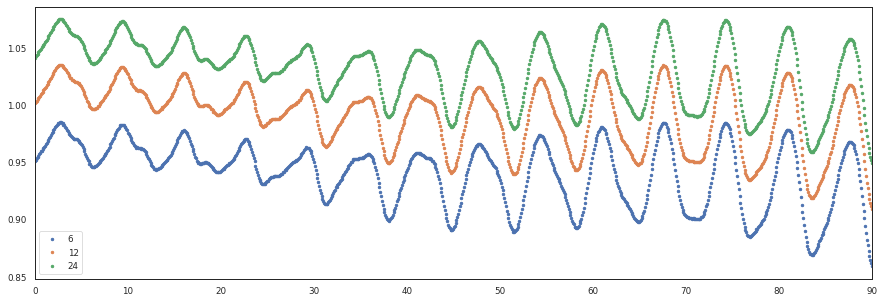

In [13]:
plt.figure(figsize=(15,5))
plt.plot(lcs[nl].time,lcs[nl].a_6 ,'.',label='6')
plt.plot(lcs[nl].time,lcs[nl].a_12+0.05,'.',label='12')
plt.plot(lcs[nl].time,lcs[nl].a_24+0.09,'.',label='24')
plt.xlim(t.min(),t.max())
plt.legend(frameon=True)

## LEt us test for light curves with different levels of white noise

In [14]:
#LEt us create the PLATO-like data for all cameras adding a new attribute to the lcs[i] instances
#All stars will have the same trends
sig = 0.005
for i in range(N_l):
    lcs[i].plato_wn5ppt = republic.platorize(lcs[i].flux,T_master,J,N,K,sig=sig)
#50 times more white noise
sig = 0.025
for i in range(N_l):
    lcs[i].plato_wn25ppt = republic.platorize(lcs[i].flux,T_master,J,N,K,sig=sig)

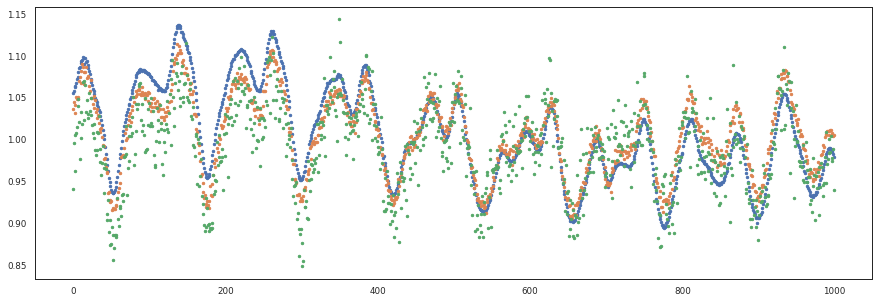

In [15]:
plt.figure(figsize=(15,5))
plt.plot(lcs[0].plato[0],'.')
plt.plot(lcs[0].plato_wn5ppt[0],'.')
plt.plot(lcs[0].plato_wn25ppt[0],'.')

In [16]:
#let us correct the light curves with REPUBLIC
#Run republic for all cameras
for i in tqdm(range(N_l)):
    #6 cameras
    #Let us do the republic magic correcting with a different number of cameras each time
    ncam=6
    T_use = T_master[:ncam,:,:] 
    sig = 0.005
    sigma = np.zeros((ncam,K)) + sig
    lcs[i].a_6_wn5ppt, lcs[i].w_6_wn5ppt, lcs[i].B_6_wn5ppt = republic.republic_solve(lcs[i].plato_wn5ppt[0:ncam], T_use, sigma)
    sig = 0.025
    sigma = np.zeros((ncam,K)) + sig
    lcs[i].a_6_wn25ppt, lcs[i].w_6_wn25ppt, lcs[i].B_6_wn25ppt = republic.republic_solve(lcs[i].plato_wn25ppt[0:ncam], T_use, sigma)
    #12 cameras
    ncam=12
    T_use = T_master[:ncam,:,:] 
    sig = 0.005
    sigma = np.zeros((ncam,K)) + sig
    lcs[i].a_12_wn5ppt, lcs[i].w_12_wn5ppt, lcs[i].B_12_wn5ppt = republic.republic_solve(lcs[i].plato_wn5ppt[0:ncam], T_use, sigma)
    sig = 0.025
    sigma = np.zeros((ncam,K)) + sig
    lcs[i].a_12_wn25ppt, lcs[i].w_12_wn25ppt, lcs[i].B_12_wn25ppt = republic.republic_solve(lcs[i].plato_wn25ppt[0:ncam], T_use, sigma)
    #24 cameras
    ncam=24
    T_use = T_master[:ncam,:,:] 
    sig = 0.005
    sigma = np.zeros((ncam,K)) + sig
    lcs[i].a_24_wn5ppt, lcs[i].w_24_wn5ppt, lcs[i].B_24_wn5ppt = republic.republic_solve(lcs[i].plato_wn5ppt[0:ncam], T_use, sigma)
    sig = 0.025
    sigma = np.zeros((ncam,K)) + sig
    lcs[i].a_24_wn25ppt, lcs[i].w_24_wn25ppt, lcs[i].B_24_wn25ppt = republic.republic_solve(lcs[i].plato_wn25ppt[0:ncam], T_use, sigma)

100%|█████████████████████████████████████████████████████████████| 100/100 [04:48<00:00,  2.88s/it]


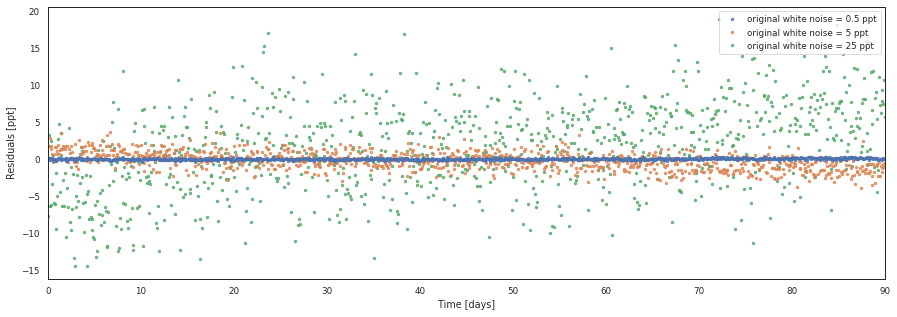

In [17]:
#Let us compare the residuals for all the cases
nlc = 0
plt.figure(figsize=(15,5),rasterized=True)
plt.plot(lcs[nlc].time,(lcs[nlc].a_24        -lcs[nlc].flux)*1e3,'.',color='C0',alpha=0.8,
         zorder=2,label='original white noise = 0.5 ppt')
plt.plot(lcs[nlc].time,(lcs[nlc].a_24_wn5ppt -lcs[nlc].flux)*1e3,'.',color='C1',alpha=0.8,
         zorder=1,label='original white noise = 5 ppt')
plt.plot(lcs[nlc].time,(lcs[nlc].a_24_wn25ppt-lcs[nlc].flux)*1e3,'.',color='C2',alpha=0.8,
         zorder=0,label='original white noise = 25 ppt')
#
plt.xlim(lcs[nlc].time.min(),lcs[nlc].time.max())
plt.legend(frameon=True,loc=1)

plt.ylabel('Residuals [ppt]')
plt.xlabel('Time [days]');
out_file = 'whitenoise_differences.pdf'
plt.savefig(out_file,bbox_inches='tight',dpi=300)

## Let's correct the light curves with a PDC-LS-like algorithm

In [18]:
#light curve by light curve
for n in tqdm(range(N_l)):
    lcs[n].pdcls = [None]*J
    #camera by camera
    for j in range(J):
        #Let us shift the fluxes to zero to be able to do PDCLS 
        basis = np.array(T_master[j,:,:])
        lcs[n].pdcls[j] = republic.PDCLS(lcs[n].plato[j]-np.mean(lcs[n].plato[j]),basis.T)
    #Combine all the light curves 
    lcs[n].pdcls_mean = np.mean(lcs[n].pdcls,axis=0)

100%|█████████████████████████████████████████████████████████████| 100/100 [03:38<00:00,  2.18s/it]


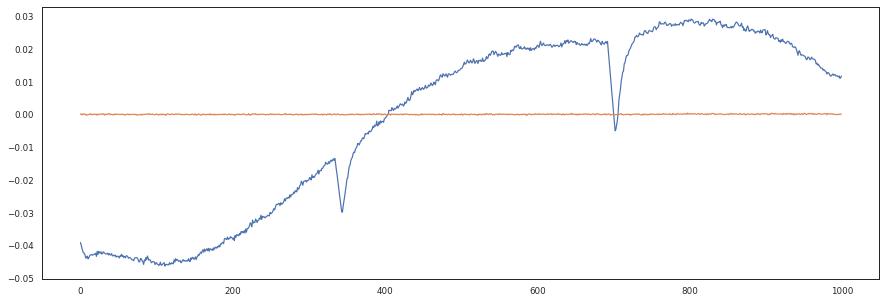

In [19]:
plt.figure(figsize=(15,5))
plt.plot(lcs[nlc].pdcls_mean-lcs[nlc].flux+np.mean(lcs[nlc].flux))
plt.plot(lcs[nlc].a_24-lcs[nlc].flux)

### Create the plot for the paper

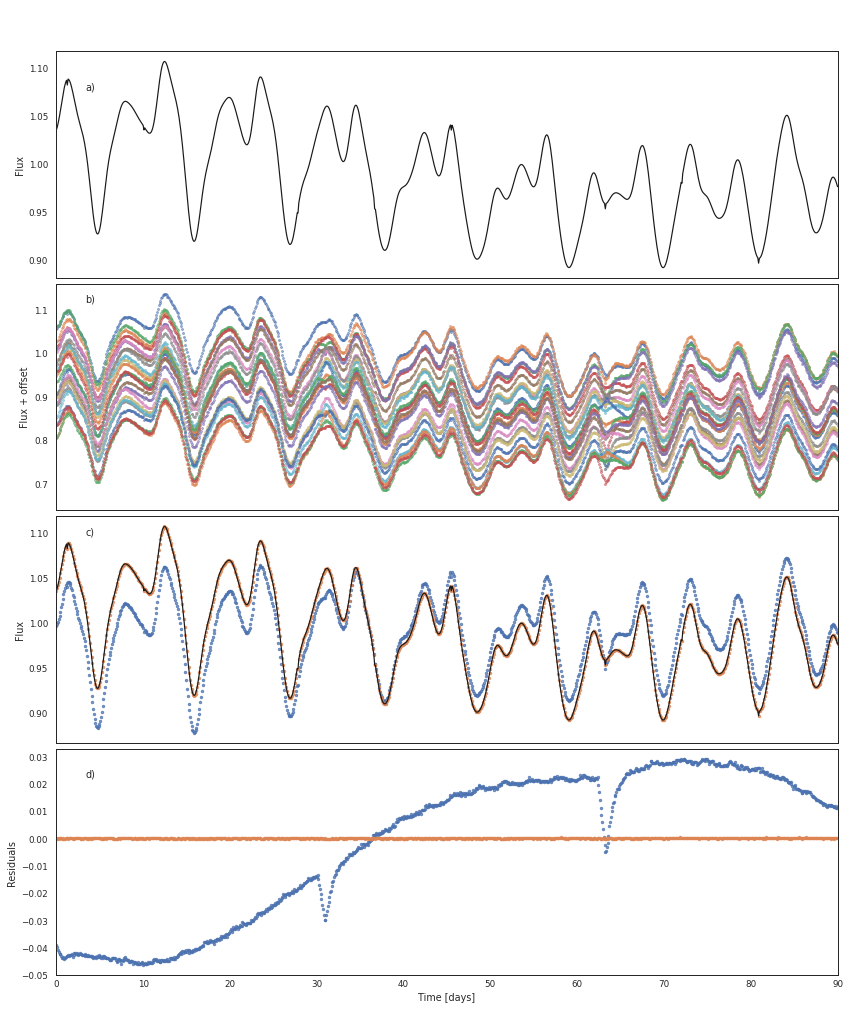

In [20]:
fig = plt.figure(1,figsize=(14,17))
gs = gridspec.GridSpec(nrows=4,ncols=1)
gs.update(hspace=0.025)
#
plt.subplot(gs[0],rasterized=True)
plt.plot(lcs[nlc].time,lcs[nlc].flux,'k-',label='True signal')
plt.xlim(lcs[nlc].time.min(),lcs[nlc].time.max())
plt.tick_params(axis='x', which='both', direction='in',labelbottom=False)
plt.ylabel('Flux')
plt.annotate('a)',(0.1,0.91),xycoords='subfigure fraction')
#
plt.subplot(gs[1],rasterized=True)
for j in range(J):
    if j == 0:
        plt.plot(lcs[nlc].time,lcs[nlc].plato[j],'o',lw=0.75,alpha=.5, label = 'LC cameras',markersize=2)
    else:
        plt.plot(lcs[nlc].time,lcs[nlc].plato[j]-j*0.01,'o',lw=0.75,alpha=.5,markersize=2)
plt.xlim(lcs[nlc].time.min(),lcs[nlc].time.max())
plt.tick_params(axis='x', which='both', direction='in',labelbottom=False)
plt.ylabel('Flux + offset')
plt.annotate('b)',(0.1,0.7),xycoords='subfigure fraction')
#
plt.subplot(gs[2],rasterized=True)
plt.plot(lcs[nlc].time,lcs[nlc].pdcls_mean+np.mean(lcs[nlc].flux),'C0.',label='PDCLS',alpha=0.75)
plt.plot(lcs[nlc].time,lcs[nlc].a_24,'C1.',label='REPUBLIC',alpha=0.75)
plt.plot(lcs[nlc].time,lcs[nlc].flux,'k-',label='True signal')
plt.xlim(lcs[nlc].time.min(),lcs[nlc].time.max())
plt.tick_params(axis='x', which='both', direction='in',labelbottom=False)
plt.ylabel('Flux')
plt.annotate('c)',(0.1,0.47),xycoords='subfigure fraction')
#
plt.subplot(gs[3],rasterized=True)
plt.plot(lcs[nlc].time,lcs[nlc].pdcls_mean-lcs[nlc].flux+np.mean(lcs[nlc].flux),'C0.',
         label='PDCLS $-$ True',alpha=0.75)
plt.plot(lcs[nlc].time,lcs[nlc].a_24-lcs[nlc].flux,'C1.',label='REPUBLIC $-$ True',alpha=0.75)
plt.xlim(lcs[nlc].time.min(),lcs[nlc].time.max())
plt.tick_params(axis='x', which='both', direction='in',labelbottom=True)
plt.xlabel('Time [days]')
plt.ylabel('Residuals')
plt.annotate('d)',(0.1,0.23),xycoords='subfigure fraction')
out_file = 'lc.pdf'
plt.savefig(out_file,bbox_inches='tight',dpi=300)
#plt.savefig('republic-broken.png',bbox_inches='tight',dpi=300)

### Extract the trends with PCA

In [21]:
#Let us do a PCA for one single camera j
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

N_components = 4

#Let us create an array to store the trends obtained with CBVs
T_CBV = np.ones((J,K,N_components)) 

#Here we need all the light curve N_lcs (not N_l) to extract the best CBVs
data = [None]*N_lcs

#camera by camera
for j in tqdm(range(J)):
    #light curve by light curve
    for i in range(N_lcs):
        data[i] = lcs[i].plato[j]
    #Now data has the information for all the light curves for a given camera
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(np.array(data).T)
    #Apply PCA
    pca = PCA()
    pca_result = pca.fit_transform(data_standardized)
    pca_components = PCA(n_components=N_components)
    #extract the components
    transformed_data = pca_components.fit_transform(data_standardized)
    transformed_data_df = pd.DataFrame(transformed_data)
    #Save the recovered PCA components in the T_CBV array to be used by republic
    for k in range(N_components):
        T_CBV[j,:,k] = transformed_data_df[k] 
        T_CBV[j,:,k] = (T_CBV[j,:,k] - T_CBV[j,:,k].min()) / (T_CBV[j,:,k].max() - T_CBV[j,:,k].min()) - 0.5

100%|███████████████████████████████████████████████████████████████| 24/24 [00:16<00:00,  1.46it/s]


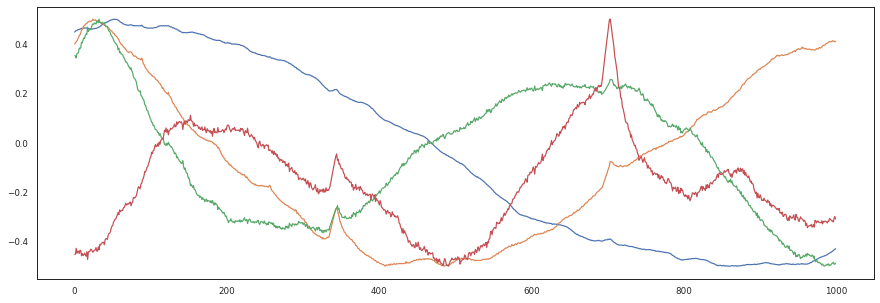

In [22]:
#Let us plot the extracted trends
plt.figure(figsize=(15,5))
for k in range(N_components):
    plt.plot(T_CBV[0,:,k])

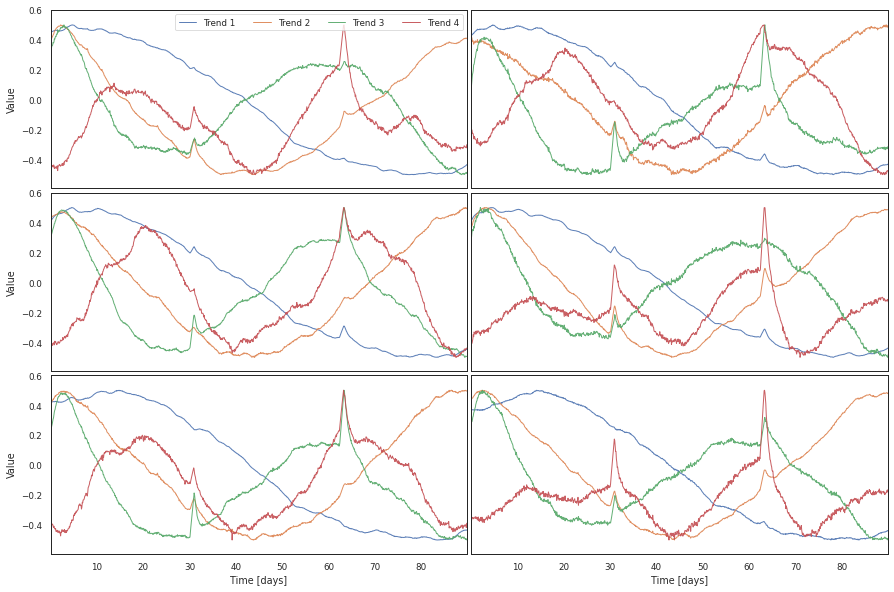

In [23]:
#Create a plot with the systematics of different cameras
fig = plt.figure(1,figsize=(15,10))
gs = gridspec.GridSpec(nrows=3,ncols=2)
gs.update(hspace=0.025)
gs.update(wspace=0.01)
cameras = [0,1,2,3,4,5]
#
for i,cam in enumerate(cameras):
    plt.subplot(gs[i])
    for j in range(N):
        if i == 0:
            plt.plot(t,T_CBV[cam,:,j],alpha=0.9,label='Trend '+str(j+1),lw=1)
        else:
            plt.plot(t,T_CBV[cam,:,j],alpha=0.9,lw=1)
    if i == 0:
        plt.legend(loc=1,ncols=4,frameon=True)
    if i%gs.ncols != 0:
        plt.tick_params(axis='y',labelleft=False,left=False)
    else:
        plt.ylabel('Value')
    plt.xlabel('Time [days]')
    plt.xlim(0.01,89.9)
    plt.ylim(-0.59,0.6)

out_file = 'trends_PCA.pdf'
plt.savefig(out_file,bbox_inches='tight',dpi=300)

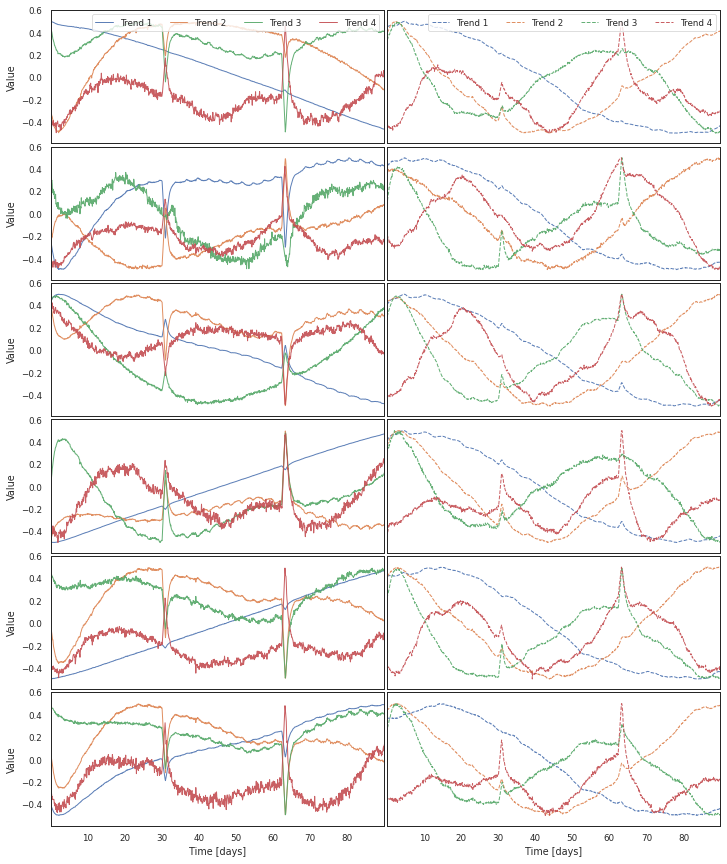

In [24]:
#Combined plot
#Create a plot with the systematics of different cameras
fig = plt.figure(1,figsize=(12,15))
gs = gridspec.GridSpec(nrows=6,ncols=2)
gs.update(hspace=0.025)
gs.update(wspace=0.01)
cameras = [0,1,2,3,4,5]
colors=['C0','C1','C2','C3']
#
for i,cam in enumerate(cameras):
    
#
    plt.subplot(gs[i*2])
    for j in range(N):
        if i == 0:
            plt.plot(t,T_master[cam,:,j],alpha=0.9,label='Trend '+str(j+1),lw=1,ls='-',color=colors[j])
        else:
            plt.plot(t,T_master[cam,:,j],alpha=0.9,lw=1,ls='-',color=colors[j])
        if i == 0:
            plt.legend(loc=1,ncols=4,frameon=True)

        plt.ylabel('Value')
    
    plt.xlabel('Time [days]')
    plt.xlim(0.01,89.9)
    plt.ylim(-0.59,0.6)
#

    plt.subplot(gs[i*2+1])
    for j in range(N):
        if i == 0:
            plt.plot(t,T_CBV[cam,:,j],alpha=0.9,label='Trend '+str(j+1),lw=1,color=colors[j],ls='--')
        else:
            plt.plot(t,T_CBV[cam,:,j],alpha=0.9,lw=1,color=colors[j],ls='--')
    if i == 0:
        plt.legend(loc=1,ncols=4,frameon=True)

    if i*2%gs.ncols == 0:
        plt.tick_params(axis='y',labelleft=False,left=False)
    else:
        plt.ylabel('Value')
        
    plt.xlabel('Time [days]')
    plt.xlim(0.01,89.9)
    plt.ylim(-0.59,0.6)

out_file = 'trends_PCA.pdf'
plt.savefig(out_file,bbox_inches='tight',dpi=300)

In [25]:
#Now let us correct the light curves with this
ncam=24
for n in tqdm(range(N_l)):
    T_use = T_CBV[:ncam,:,:] 
    sigma = np.zeros((ncam,K)) + sig
    lcs[n].a_pca, lcs[n].w_pca, lcs[n].B_pca = republic.republic_solve(lcs[n].plato[:ncam], T_use, sigma)

100%|█████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


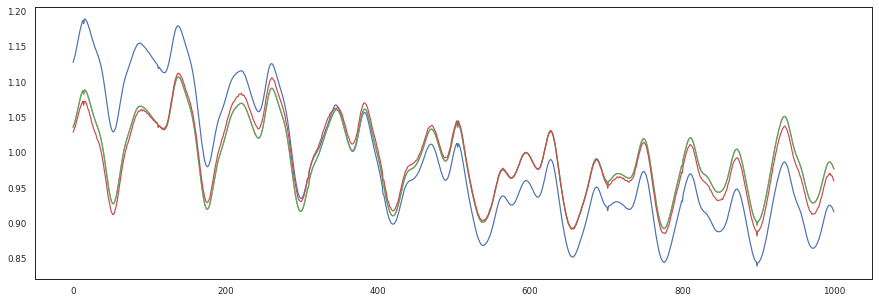

In [26]:
nlc = 0
plt.figure(figsize=(15,5))
plt.plot(lcs[nlc].a_pca)
plt.plot(lcs[nlc].a_24)
plt.plot(lcs[nlc].flux)
plt.plot(lcs[nlc].plato[5])

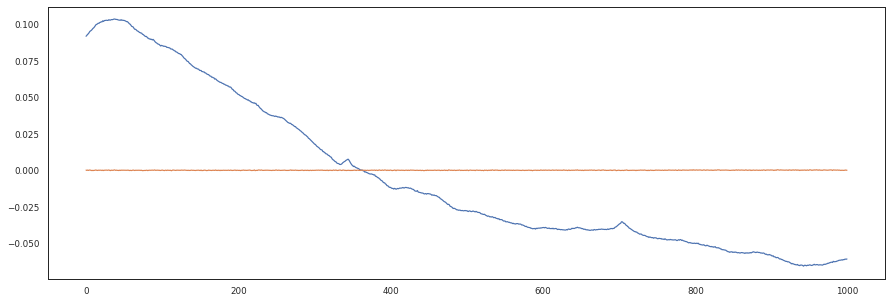

In [27]:
plt.figure(figsize=(15,5))
plt.plot(lcs[nlc].a_pca-lcs[nlc].flux)
plt.plot(lcs[nlc].a_24-lcs[nlc].flux)

### How the PDCLS behave with the imperfect trends

In [28]:
#light curve by light curve
for n in tqdm(range(N_l)):
    lcs[n].pdcls_cbv = [None]*J
    #camera by camera
    for j in range(J):
        #Let us shift the fluxes to zero to be able to do PDCLS 
        basis = np.array(T_CBV[j,:,:])
        lcs[n].pdcls_cbv[j] = republic.PDCLS(lcs[n].plato[j]-np.mean(lcs[n].plato[j]),basis.T)
    #Combine all the light curves 
    lcs[n].pdcls_mean_cbv = np.mean(lcs[n].pdcls_cbv,axis=0)

100%|█████████████████████████████████████████████████████████████| 100/100 [03:28<00:00,  2.09s/it]


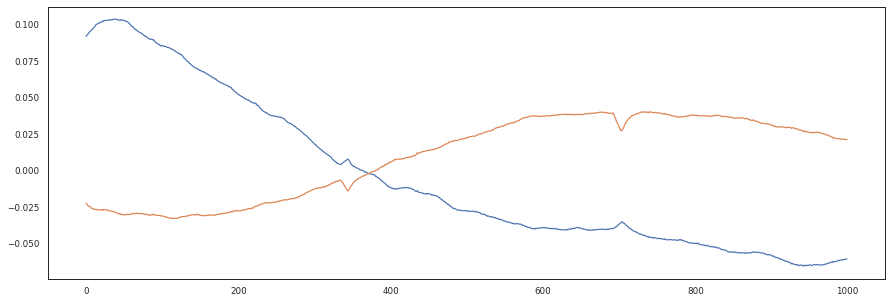

In [29]:
plt.figure(figsize=(15,5))
plt.plot(lcs[nlc].a_pca-lcs[nlc].flux)
plt.plot(lcs[nlc].pdcls_mean_cbv-lcs[nlc].flux+1)

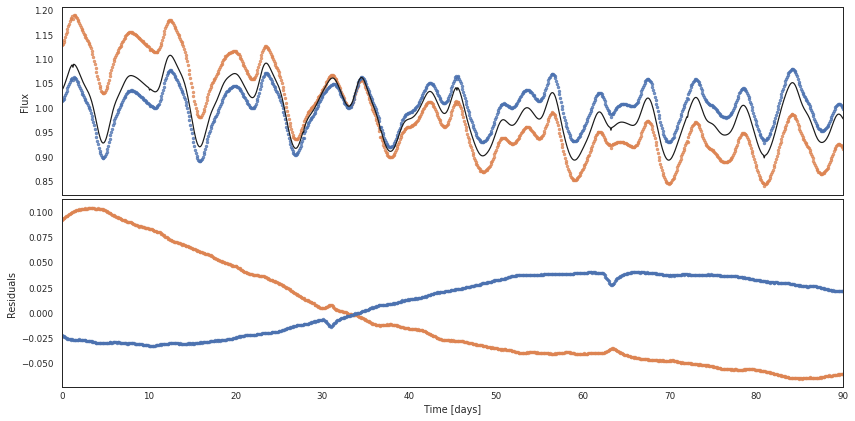

In [30]:
fig = plt.figure(1,figsize=(14,7))
gs = gridspec.GridSpec(nrows=2,ncols=1)
gs.update(hspace=0.025)
#
plt.subplot(gs[0],rasterized=True)
plt.plot(lcs[nlc].time,lcs[nlc].a_pca,'C1.',label='REPUBLIC with PCA',alpha=0.75)
plt.plot(lcs[nlc].time,lcs[nlc].pdcls_mean_cbv+1,'C0.',label='PDCLS with PCA',alpha=0.75)
plt.plot(lcs[nlc].time,lcs[nlc].flux,'k-',label='True signal')
plt.xlim(lcs[nlc].time.min(),lcs[nlc].time.max())
plt.tick_params(axis='x', which='both', direction='in',labelbottom=False)
plt.ylabel('Flux')
#
plt.subplot(gs[1],rasterized=True)
plt.plot(lcs[nlc].time,lcs[nlc].a_pca-lcs[nlc].flux,'C1.',label='REPUBLIC with PCA',alpha=0.75)
plt.plot(lcs[nlc].time,lcs[nlc].pdcls_mean_cbv-lcs[nlc].flux+1,'C0.',label='PDCLS with PCA',alpha=0.75)
plt.xlim(lcs[nlc].time.min(),lcs[nlc].time.max())
plt.tick_params(axis='x', which='both', direction='in',labelbottom=True)
plt.xlabel('Time [days]')
plt.ylabel('Residuals')
out_file = 'lc_nonidealcase.pdf'
plt.savefig(out_file,bbox_inches='tight',dpi=300)

# Correlated trends

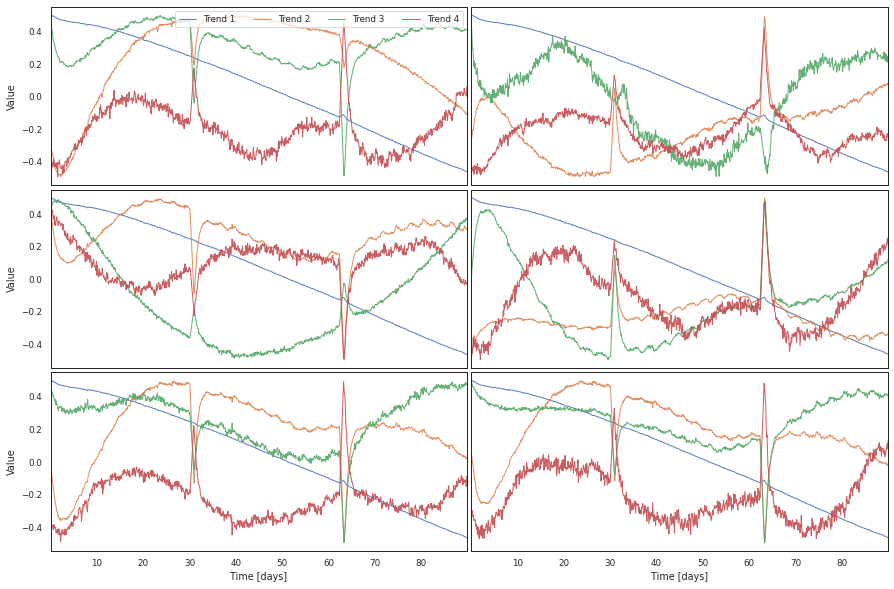

In [31]:
#Create correlated trends
#We will make that the first trend in all cameras is identical
T_correlated = np.array(T_master)
for i in range(1,J):
    T_correlated[i,:,0] = T_master[0,:,0]


    
#Check visually that this works
#
#Create a plot with the systematics of different cameras
fig = plt.figure(1,figsize=(15,10))
gs = gridspec.GridSpec(nrows=3,ncols=2)
gs.update(hspace=0.025)
gs.update(wspace=0.01)
cameras = [0,1,2,3,4,5]
#

for i,cam in enumerate(cameras):
    plt.subplot(gs[i])
    for j in range(N):
        if i == 0:
            plt.plot(t,T_correlated[cam,:,j],alpha=0.9,label='Trend '+str(j+1),lw=1)
        else:
            plt.plot(t,T_correlated[cam,:,j],alpha=0.9,lw=1)
    if i == 0:
        plt.legend(loc=1,ncols=4,frameon=True)
    if i%gs.ncols != 0:
        plt.tick_params(axis='y',labelleft=False,left=False)
    else:
        plt.ylabel('Value')
    plt.xlabel('Time [days]')
    plt.xlim(0.01,89.9)

In [32]:
#Now let us create PLATO light curves using these correlated systematics
#We add a new attribute called plato_corr, similar to plato but with correlated systematics
sig = 0.0005
for i in tqdm(range(N_lcs)):
    lcs[i].plato_corr = republic.platorize(lcs[i].flux,T_correlated,J,N,K,sig=sig)

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 925.64it/s]


In [33]:
#Now let us apply republic to this
#Run republic for 24 cameras
for i in tqdm(range(N_l)):
    #24 cameras
    ncam=24
    T_use = T_correlated[:ncam,:,:] 
    sigma = np.zeros((ncam,K)) + sig
    lcs[i].a_corr, lcs[i].w_corr, lcs[i].B_corr = republic.republic_solve(lcs[i].plato_corr[0:ncam], T_use, sigma)

  1%|▋                                                              | 1/100 [00:00<00:50,  1.94it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


  2%|█▎                                                             | 2/100 [00:01<01:02,  1.57it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


  3%|█▉                                                             | 3/100 [00:01<01:02,  1.56it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


  4%|██▌                                                            | 4/100 [00:02<01:03,  1.52it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


  5%|███▏                                                           | 5/100 [00:03<01:02,  1.53it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


  6%|███▊                                                           | 6/100 [00:04<01:07,  1.39it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


  7%|████▍                                                          | 7/100 [00:04<01:05,  1.42it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


  8%|█████                                                          | 8/100 [00:05<01:03,  1.44it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


  9%|█████▋                                                         | 9/100 [00:06<01:09,  1.32it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 10%|██████▏                                                       | 10/100 [00:06<01:05,  1.38it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 11%|██████▊                                                       | 11/100 [00:07<01:02,  1.42it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 12%|███████▍                                                      | 12/100 [00:08<01:01,  1.44it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 13%|████████                                                      | 13/100 [00:08<00:59,  1.45it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 14%|████████▋                                                     | 14/100 [00:09<00:58,  1.47it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 15%|█████████▎                                                    | 15/100 [00:10<00:57,  1.48it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 16%|█████████▉                                                    | 16/100 [00:11<01:05,  1.28it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 17%|██████████▌                                                   | 17/100 [00:11<01:01,  1.35it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 18%|███████████▏                                                  | 18/100 [00:12<00:58,  1.41it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 19%|███████████▊                                                  | 19/100 [00:13<00:57,  1.41it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 20%|████████████▍                                                 | 20/100 [00:13<00:54,  1.46it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 21%|█████████████                                                 | 21/100 [00:14<00:55,  1.43it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 22%|█████████████▋                                                | 22/100 [00:15<00:53,  1.46it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 23%|██████████████▎                                               | 23/100 [00:16<00:55,  1.38it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 24%|██████████████▉                                               | 24/100 [00:16<00:52,  1.44it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 25%|███████████████▌                                              | 25/100 [00:17<00:50,  1.48it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 26%|████████████████                                              | 26/100 [00:18<00:52,  1.41it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 27%|████████████████▋                                             | 27/100 [00:18<00:50,  1.44it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 28%|█████████████████▎                                            | 28/100 [00:19<00:49,  1.46it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 29%|█████████████████▉                                            | 29/100 [00:20<00:47,  1.49it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 30%|██████████████████▌                                           | 30/100 [00:20<00:48,  1.44it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 31%|███████████████████▏                                          | 31/100 [00:21<00:46,  1.48it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 32%|███████████████████▊                                          | 32/100 [00:22<00:45,  1.50it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 33%|████████████████████▍                                         | 33/100 [00:22<00:44,  1.49it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 34%|█████████████████████                                         | 34/100 [00:23<00:43,  1.51it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 35%|█████████████████████▋                                        | 35/100 [00:24<00:42,  1.51it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 36%|██████████████████████▎                                       | 36/100 [00:24<00:42,  1.52it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 37%|██████████████████████▉                                       | 37/100 [00:25<00:44,  1.42it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 38%|███████████████████████▌                                      | 38/100 [00:26<00:43,  1.43it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 39%|████████████████████████▏                                     | 39/100 [00:26<00:41,  1.46it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 40%|████████████████████████▊                                     | 40/100 [00:27<00:42,  1.42it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 41%|█████████████████████████▍                                    | 41/100 [00:28<00:41,  1.44it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 42%|██████████████████████████                                    | 42/100 [00:29<00:39,  1.47it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 43%|██████████████████████████▋                                   | 43/100 [00:29<00:38,  1.49it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 44%|███████████████████████████▎                                  | 44/100 [00:30<00:41,  1.36it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 45%|███████████████████████████▉                                  | 45/100 [00:31<00:38,  1.41it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 46%|████████████████████████████▌                                 | 46/100 [00:31<00:37,  1.45it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 47%|█████████████████████████████▏                                | 47/100 [00:32<00:41,  1.28it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 48%|█████████████████████████████▊                                | 48/100 [00:33<00:38,  1.35it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 49%|██████████████████████████████▍                               | 49/100 [00:34<00:36,  1.39it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 50%|███████████████████████████████                               | 50/100 [00:34<00:34,  1.44it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 51%|███████████████████████████████▌                              | 51/100 [00:35<00:33,  1.45it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 52%|████████████████████████████████▏                             | 52/100 [00:36<00:32,  1.48it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 53%|████████████████████████████████▊                             | 53/100 [00:36<00:31,  1.50it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 54%|█████████████████████████████████▍                            | 54/100 [00:37<00:33,  1.37it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 55%|██████████████████████████████████                            | 55/100 [00:38<00:31,  1.42it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 56%|██████████████████████████████████▋                           | 56/100 [00:38<00:30,  1.46it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 57%|███████████████████████████████████▎                          | 57/100 [00:39<00:28,  1.49it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 58%|███████████████████████████████████▉                          | 58/100 [00:40<00:29,  1.44it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 59%|████████████████████████████████████▌                         | 59/100 [00:41<00:28,  1.44it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 60%|█████████████████████████████████████▏                        | 60/100 [00:41<00:27,  1.45it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 61%|█████████████████████████████████████▊                        | 61/100 [00:42<00:31,  1.23it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 62%|██████████████████████████████████████▍                       | 62/100 [00:43<00:29,  1.30it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 63%|███████████████████████████████████████                       | 63/100 [00:44<00:27,  1.35it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 64%|███████████████████████████████████████▋                      | 64/100 [00:45<00:29,  1.23it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 65%|████████████████████████████████████████▎                     | 65/100 [00:45<00:26,  1.30it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 66%|████████████████████████████████████████▉                     | 66/100 [00:46<00:25,  1.35it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 67%|█████████████████████████████████████████▌                    | 67/100 [00:47<00:26,  1.24it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 68%|██████████████████████████████████████████▏                   | 68/100 [00:48<00:24,  1.30it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 69%|██████████████████████████████████████████▊                   | 69/100 [00:48<00:22,  1.35it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 70%|███████████████████████████████████████████▍                  | 70/100 [00:49<00:21,  1.40it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 71%|████████████████████████████████████████████                  | 71/100 [00:50<00:20,  1.39it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 72%|████████████████████████████████████████████▋                 | 72/100 [00:50<00:19,  1.42it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 73%|█████████████████████████████████████████████▎                | 73/100 [00:51<00:18,  1.44it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 74%|█████████████████████████████████████████████▉                | 74/100 [00:52<00:19,  1.36it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 75%|██████████████████████████████████████████████▌               | 75/100 [00:52<00:17,  1.40it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 76%|███████████████████████████████████████████████               | 76/100 [00:53<00:16,  1.42it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 77%|███████████████████████████████████████████████▋              | 77/100 [00:54<00:16,  1.42it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 78%|████████████████████████████████████████████████▎             | 78/100 [00:55<00:15,  1.45it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 79%|████████████████████████████████████████████████▉             | 79/100 [00:55<00:14,  1.47it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 80%|█████████████████████████████████████████████████▌            | 80/100 [00:56<00:13,  1.49it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 81%|██████████████████████████████████████████████████▏           | 81/100 [00:57<00:13,  1.44it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 82%|██████████████████████████████████████████████████▊           | 82/100 [00:57<00:12,  1.45it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 83%|███████████████████████████████████████████████████▍          | 83/100 [00:58<00:11,  1.47it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 84%|████████████████████████████████████████████████████          | 84/100 [00:59<00:12,  1.31it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 85%|████████████████████████████████████████████████████▋         | 85/100 [01:00<00:11,  1.35it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 86%|█████████████████████████████████████████████████████▎        | 86/100 [01:00<00:10,  1.38it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 87%|█████████████████████████████████████████████████████▉        | 87/100 [01:01<00:09,  1.39it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 88%|██████████████████████████████████████████████████████▌       | 88/100 [01:02<00:08,  1.43it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 89%|███████████████████████████████████████████████████████▏      | 89/100 [01:02<00:07,  1.43it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 90%|███████████████████████████████████████████████████████▊      | 90/100 [01:03<00:06,  1.44it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 91%|████████████████████████████████████████████████████████▍     | 91/100 [01:04<00:06,  1.37it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 92%|█████████████████████████████████████████████████████████     | 92/100 [01:04<00:05,  1.41it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 93%|█████████████████████████████████████████████████████████▋    | 93/100 [01:05<00:04,  1.43it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 94%|██████████████████████████████████████████████████████████▎   | 94/100 [01:06<00:04,  1.29it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 95%|██████████████████████████████████████████████████████████▉   | 95/100 [01:07<00:03,  1.34it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 96%|███████████████████████████████████████████████████████████▌  | 96/100 [01:07<00:02,  1.38it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 97%|████████████████████████████████████████████████████████████▏ | 97/100 [01:08<00:02,  1.35it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 98%|████████████████████████████████████████████████████████████▊ | 98/100 [01:09<00:01,  1.39it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


 99%|█████████████████████████████████████████████████████████████▍| 99/100 [01:10<00:00,  1.44it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


100%|█████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]

LARGE MATRIX CONDITION NUMBER 1.3900583186072236e+19!
RISK OF REPUBLIC FAILING!!


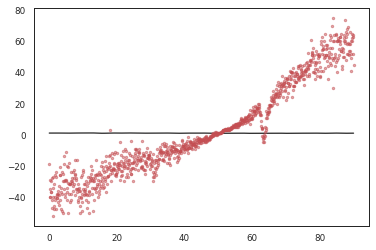

In [34]:
plt.plot(lcs[nlc].time,lcs[nlc].flux,'k-',label='True signal')
plt.plot(lcs[nlc].time,lcs[nlc].a_corr,'C3.',label='REPUBLIC $-$ True',alpha=0.5)

## Now we will use the PDC-like algorithm to correct with the correlated systematics

In [35]:
#light curve by light curve
for n in tqdm(range(N_l)):
    lcs[n].pdcls_corr = [None]*J
    #camera by camera
    for j in range(J):
        #Let us shift the fluxes to zero to be able to do PDCLS 
        basis = np.array(T_correlated[j,:,:])
        lcs[n].pdcls_corr[j] = republic.PDCLS(lcs[n].plato[j]-np.mean(lcs[n].plato_corr[j]),basis.T)
    #Combine all the light curves 
    lcs[n].pdcls_mean_corr = np.mean(lcs[n].pdcls_corr,axis=0)

100%|█████████████████████████████████████████████████████████████| 100/100 [03:39<00:00,  2.19s/it]


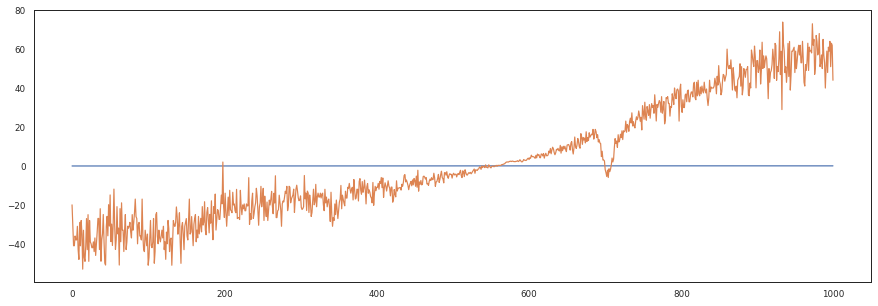

In [36]:
plt.figure(figsize=(15,5))
plt.plot(lcs[nlc].pdcls_mean_corr-lcs[nlc].flux+np.mean(lcs[nlc].flux))
plt.plot(lcs[nlc].a_corr-lcs[nlc].flux)

## Let us extract the correlated CBVs from the correlated case

In [37]:
N_components = 4

#Let us create an array to store the trends obtained with CBVs
T_CBV_corr = np.ones((J,K,N_components)) 

#Here we need all the light curve N_lcs (not N_l) to extract the best CBVs
data = [None]*N_lcs

#camera by camera
for j in tqdm(range(J)):
    #light curve by light curve
    for i in range(N_lcs):
        data[i] = lcs[i].plato_corr[j]
    #Now data has the information for all the light curves for a given camera
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(np.array(data).T)
    #Apply PCA
    pca = PCA()
    pca_result = pca.fit_transform(data_standardized)
    pca_components = PCA(n_components=N_components)
    #extract the components
    transformed_data = pca_components.fit_transform(data_standardized)
    transformed_data_df = pd.DataFrame(transformed_data)
    #Save the recovered PCA components in the T_CBV array to be used by republic
    for k in range(N_components):
        T_CBV_corr[j,:,k] = transformed_data_df[k] 
        T_CBV_corr[j,:,k] = (T_CBV_corr[j,:,k] - T_CBV_corr[j,:,k].min()) / (T_CBV_corr[j,:,k].max() - T_CBV_corr[j,:,k].min()) - 0.5

100%|███████████████████████████████████████████████████████████████| 24/24 [00:16<00:00,  1.49it/s]


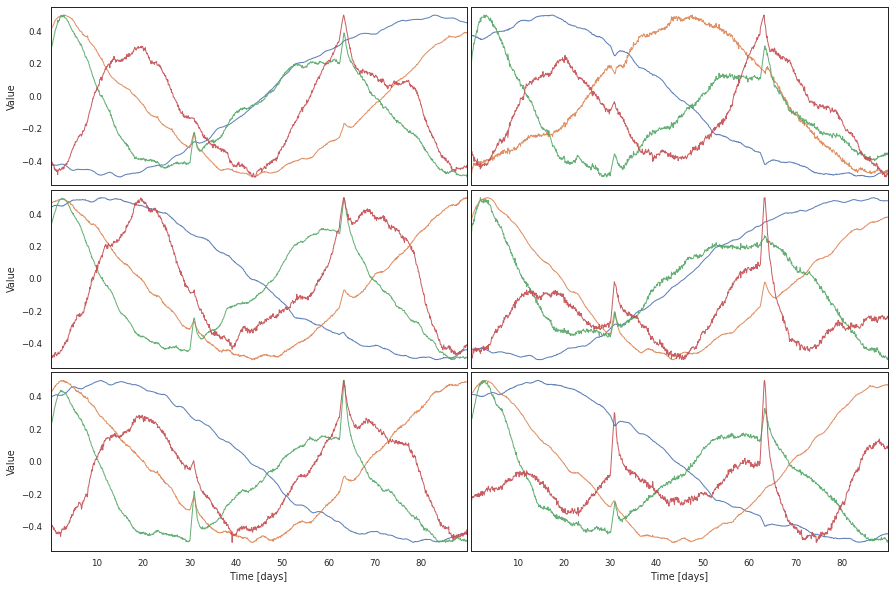

In [38]:
#Create a plot with the systematics of different cameras
fig = plt.figure(1,figsize=(15,10))
gs = gridspec.GridSpec(nrows=3,ncols=2)
gs.update(hspace=0.025)
gs.update(wspace=0.01)
cameras = [0,1,2,3,4,5]
#

for i,cam in enumerate(cameras):
    plt.subplot(gs[i])
    for j in range(N):
        if i == 0:
            plt.plot(t,T_CBV_corr[cam,:,j],alpha=0.9,label='Trend '+str(j+1),lw=1)
        else:
            plt.plot(t,T_CBV_corr[cam,:,j],alpha=0.9,lw=1)
    if i%gs.ncols != 0:
        plt.tick_params(axis='y',labelleft=False,left=False)
    else:
        plt.ylabel('Value')
    plt.xlabel('Time [days]')
    plt.xlim(0.01,89.9)

In [39]:
#Now let us apply republic to this
#Run republic for 24 cameras
for i in tqdm(range(N_l)):
    #24 cameras
    ncam=24
    T_use = T_CBV_corr[:ncam,:,:] 
    sigma = np.zeros((ncam,K)) + sig
    lcs[i].a_corr_cbv, lcs[i].w_corr_cbv, lcs[i].B_corr_cbv = republic.republic_solve(lcs[i].plato_corr[0:ncam], T_use, sigma)

100%|█████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


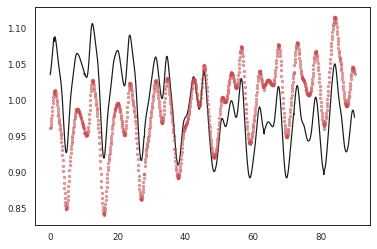

In [40]:
plt.plot(lcs[nlc].time,lcs[nlc].flux,'k-',label='True signal')
plt.plot(lcs[nlc].time,lcs[nlc].a_corr_cbv,'C3.',label='REPUBLIC $-$ True',alpha=0.5)

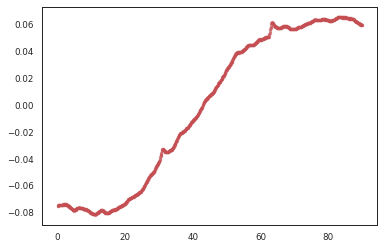

In [41]:
plt.plot(lcs[nlc].time,lcs[nlc].a_corr_cbv-lcs[nlc].flux,'C3.',label='REPUBLIC $-$ True',alpha=0.5)

### LET's make the plot of the correlated trends

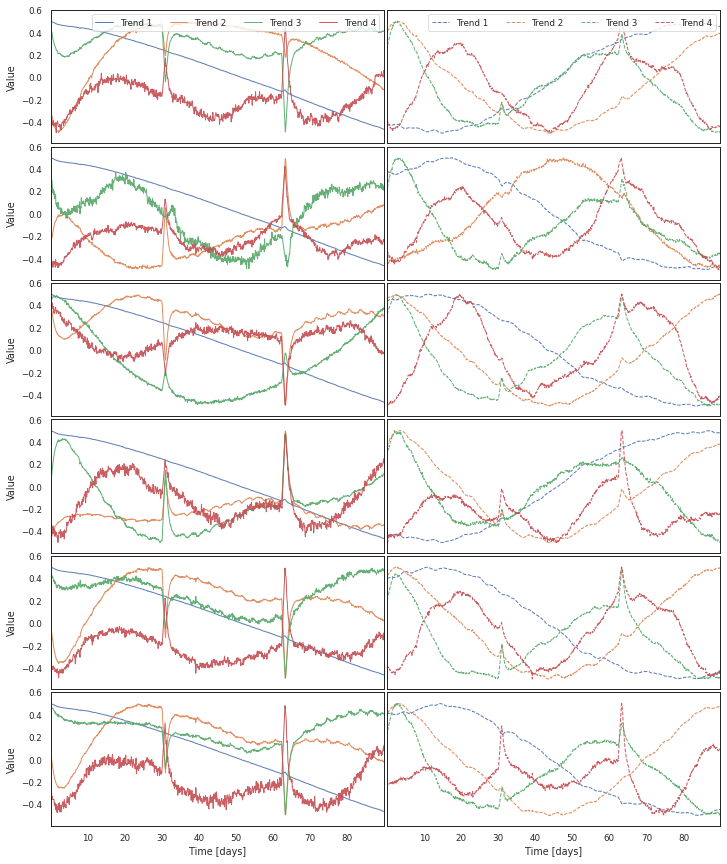

In [42]:
#Combined plot
#Create a plot with the systematics of different cameras
fig = plt.figure(1,figsize=(12,15))
gs = gridspec.GridSpec(nrows=6,ncols=2)
gs.update(hspace=0.025)
gs.update(wspace=0.01)
cameras = [0,1,2,3,4,5]
colors=['C0','C1','C2','C3']
#
for i,cam in enumerate(cameras):
    
#
    plt.subplot(gs[i*2])
    for j in range(N):
        if i == 0:
            plt.plot(t,T_correlated[cam,:,j],alpha=0.9,label='Trend '+str(j+1),lw=1,ls='-',color=colors[j])
        else:
            plt.plot(t,T_correlated[cam,:,j],alpha=0.9,lw=1,ls='-',color=colors[j])
        if i == 0:
            plt.legend(loc=1,ncols=4,frameon=True)

        plt.ylabel('Value')
    
    plt.xlabel('Time [days]')
    plt.xlim(0.01,89.9)
    plt.ylim(-0.59,0.6)
#

    plt.subplot(gs[i*2+1])
    for j in range(N):
        if i == 0:
            plt.plot(t,T_CBV_corr[cam,:,j],alpha=0.9,label='Trend '+str(j+1),lw=1,color=colors[j],ls='--')
        else:
            plt.plot(t,T_CBV_corr[cam,:,j],alpha=0.9,lw=1,color=colors[j],ls='--')
    if i == 0:
        plt.legend(loc=1,ncols=4,frameon=True)

    if i*2%gs.ncols == 0:
        plt.tick_params(axis='y',labelleft=False,left=False)
    else:
        plt.ylabel('Value')
        
    plt.xlabel('Time [days]')
    plt.xlim(0.01,89.9)
    plt.ylim(-0.59,0.6)

out_file = 'trends_correlated.pdf'
plt.savefig(out_file,bbox_inches='tight',dpi=300)

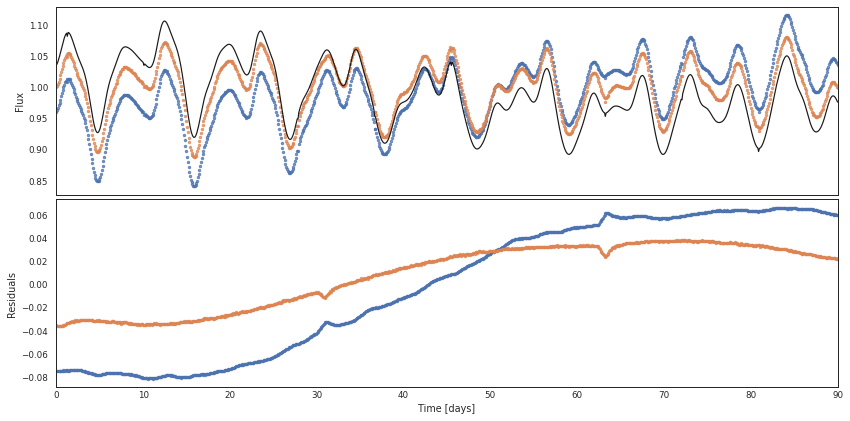

In [43]:
fig = plt.figure(1,figsize=(14,7))
gs = gridspec.GridSpec(nrows=2,ncols=1)
gs.update(hspace=0.025)
#
plt.subplot(gs[0],rasterized=True)
plt.plot(lcs[nlc].time,lcs[nlc].a_corr_cbv,'C0.',label='REPUBLIC with PCA',alpha=0.75)
plt.plot(lcs[nlc].time,lcs[nlc].pdcls_mean_corr+1,'C1.',label='PDCLS with PCA',alpha=0.75)


#NEED TO ADD CODE TOCOMPUTE THE LS CORRECTION
plt.plot(lcs[nlc].time,lcs[nlc].flux,'k-',label='True signal')
plt.xlim(lcs[nlc].time.min(),lcs[nlc].time.max())
plt.tick_params(axis='x', which='both', direction='in',labelbottom=False)
plt.ylabel('Flux')
#
plt.subplot(gs[1],rasterized=True)
plt.plot(lcs[nlc].time,lcs[nlc].a_corr_cbv-lcs[nlc].flux,'C0.',label='REPUBLIC with PCA',alpha=0.75)
plt.plot(lcs[nlc].time,lcs[nlc].pdcls_mean_corr-lcs[nlc].flux+1,'C1.',label='PDCLS with PCA',alpha=0.75)
plt.xlim(lcs[nlc].time.min(),lcs[nlc].time.max())
plt.tick_params(axis='x', which='both', direction='in',labelbottom=True)
plt.xlabel('Time [days]')
plt.ylabel('Residuals')
out_file = 'lc_correlated.pdf'
plt.savefig(out_file,bbox_inches='tight',dpi=300)